In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
def get_shape(tensor):
    "return the shape of tensor as list"
    return tensor.get_shape().as_list()

def print_var(string):
    "print var_name and var_shape in collection named string"
    print("\n".join(["{} : {}".format(v.name, get_shape(v)) for v in tf.get_collection(string)]))
    
def clip(x, vmax = 1-1e-7, vmin = 1e-7):
    "clip the x between vmax, vmin"
    return tf.clip_by_value(x, clip_value_max=vmax, clip_value_min=vmin)

In [3]:
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
train = {}
test = {}
val = {}
train['input'] = mnist.train.images
train['output'] = mnist.train.labels
test['input'] = mnist.test.images
test['output'] = mnist.test.labels
val['input'] = mnist.validation.images
val['output'] = mnist.validation.labels

In [10]:
# Model parameter
image_size = 28*28
image_row = 28
conv_filter1 = [5, 5]
conv_channel1 = 30
nclasses = 10

# Train parameter
learning_rate = 1e-4
epoch = 5
ntrain = len(train['input'])
batch_size = 100
nbatch = ntrain//batch_size
log_every = 50

In [13]:
x = tf.placeholder(dtype = tf.float32, shape = [None, image_size], name = 'image')
y = tf.placeholder(dtype = tf.float32, shape = [None, nclasses], name = 'label')

x_reshape = tf.reshape(x, [-1, image_row, image_row, 1]) # 4D 

conv_layer1 = {}
fc_layer1 = {}

with tf.variable_scope("conv_layer1"):
    conv_layer1['w'] = tf.Variable(initial_value = tf.random_normal(shape = [conv_filter1[0], conv_filter1[1], 1, conv_channel1], mean = 0.0, stddev = 1.0),
                              name = 'weight')
    conv_layer1['b'] = tf.Variable(initial_value = tf.constant(value=0.01, shape = [30]),
                              name = 'bias')
    conv_layer1['conv'] = tf.nn.conv2d(x_reshape, conv_layer1['w'], strides = [1,1,1,1], padding = "VALID") + conv_layer1['b']
    conv_layer1['relu'] = tf.nn.relu(conv_layer1['conv'])
    conv_layer1['pool'] = tf.nn.max_pool(conv_layer1['relu'], ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    conv_shape = get_shape(conv_layer1['pool'])
    flat_size = conv_shape[1]*conv_shape[2]*conv_shape[3]
    conv_layer1['flat'] = tf.reshape(conv_layer1['pool'], [-1, flat_size])

with tf.variable_scope("fc_layer1"):
    fc_layer1['w'] = tf.Variable(initial_value = tf.random_normal(shape = [flat_size, nclasses], mean = 0.0, stddev = 1.0),
                              name = 'weight')
    fc_layer1['b'] = tf.Variable(initial_value = tf.constant(value=0.0, shape = [nclasses]),
                              name = 'bias')
    fc_layer1['output'] = tf.nn.softmax(tf.add(tf.matmul(conv_layer1['flat'], fc_layer1['w']), fc_layer1['b']))    
    
print("Reshape {} -> {}".format(get_shape(x), get_shape(x_reshape)))
print("Convolution layer 1")
print("Conv {} -> {}".format(get_shape(x_reshape), get_shape(conv_layer1['conv'])))
print("Pool {} -> {}".format(get_shape(conv_layer1['conv']), get_shape(conv_layer1['pool'])))    
print("Flat {} -> {}".format(get_shape(conv_layer1['pool']), get_shape(conv_layer1['flat'])))
print("Fully connected layer 1")
print("Linear {} -> {}".format(get_shape(conv_layer1['flat']), get_shape(fc_layer1['output'])))

Reshape [None, 784] -> [None, 28, 28, 1]
Convolution layer 1
Conv [None, 28, 28, 1] -> [None, 24, 24, 30]
Pool [None, 24, 24, 30] -> [None, 12, 12, 30]
Flat [None, 12, 12, 30] -> [None, 4320]
Fully connected layer 1
Linear [None, 4320] -> [None, 10]


In [14]:
print_var("trainable_variables")

conv_layer1/weight:0 : [5, 5, 1, 30]
conv_layer1/bias:0 : [30]
fc_layer1/weight:0 : [4320, 10]
fc_layer1/bias:0 : [10]
conv_layer1_3/weight:0 : [5, 5, 1, 30]
conv_layer1_3/bias:0 : [30]
fc_layer1_1/weight:0 : [4320, 10]
fc_layer1_1/bias:0 : [10]


### Cross entropy
$y[i][j] = $ True Label(one hot)  
$output[i][j] = $ Output of Neural Network

$$cross entropy = \sum_{i} \sum_{j=1}^{10} y[i][j]\log(output[i][j])$$

In [16]:
cross_entropy = -tf.reduce_mean(y*tf.log(clip(fc_layer1['output'])))

### tf.argmax(2Darray, axis = 1)
[http://nbviewer.jupyter.org/github/maestrojeong/tensorflow_api/blob/master/tensorflow_1.0.0/tensorflow_api.ipynb](http://nbviewer.jupyter.org/github/maestrojeong/tensorflow_api/blob/master/tensorflow_1.0.0/tensorflow_api.ipynb)

In [18]:
correct_prediction = tf.equal(tf.argmax(fc_layer1['output'], 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [19]:
run_train = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [21]:
train_accuracy_tract = []
val_accuracy_tract = []

for epoch_ in range(epoch):
    index = np.arange(len(train['input']))
    np.random.shuffle(index)
    trX = train['input'][index]
    trY = train['output'][index]
    val_feed_dict = {x : val['input'], 
                     y : val['output']}
    
    for nbatch_ in range(nbatch):
        train_feed_dict = {x : trX[batch_size*nbatch_:batch_size*(nbatch_+1)], 
                           y : trY[batch_size*nbatch_:batch_size*(nbatch_+1)]}
        sess.run(run_train, feed_dict=train_feed_dict)
        
        if nbatch_%log_every == log_every - 1:
            train_accuracy = 100*sess.run(accuracy, feed_dict=train_feed_dict)
            val_accuracy = 100*sess.run(accuracy, feed_dict= val_feed_dict)
            train_accuracy_tract.append(train_accuracy)
            val_accuracy_tract.append(val_accuracy)
            print("Epoch(%d/%d) %d th batch train : %.1f %%, validation : %.1f %%"%(epoch_+1, epoch, nbatch_+1, train_accuracy, val_accuracy))

test_feed_dict = {x : test['input'],  
                  y : test['output']}

test_accuracy = 100*sess.run(accuracy, feed_dict=test_feed_dict)
print("Test accuracy=%.1f %%"%(test_accuracy))

Epoch(1/5) 50 th batch train : 12.0 %, validation : 10.9 %
Epoch(1/5) 100 th batch train : 13.0 %, validation : 12.7 %
Epoch(1/5) 150 th batch train : 10.0 %, validation : 13.4 %
Epoch(1/5) 200 th batch train : 12.0 %, validation : 14.1 %
Epoch(1/5) 250 th batch train : 19.0 %, validation : 14.9 %
Epoch(1/5) 300 th batch train : 20.0 %, validation : 15.7 %
Epoch(1/5) 350 th batch train : 16.0 %, validation : 16.2 %
Epoch(1/5) 400 th batch train : 19.0 %, validation : 17.0 %
Epoch(1/5) 450 th batch train : 13.0 %, validation : 17.9 %
Epoch(1/5) 500 th batch train : 17.0 %, validation : 18.5 %
Epoch(1/5) 550 th batch train : 16.0 %, validation : 19.4 %
Epoch(2/5) 50 th batch train : 25.0 %, validation : 20.2 %
Epoch(2/5) 100 th batch train : 25.0 %, validation : 20.8 %
Epoch(2/5) 150 th batch train : 31.0 %, validation : 21.3 %
Epoch(2/5) 200 th batch train : 24.0 %, validation : 22.0 %
Epoch(2/5) 250 th batch train : 20.0 %, validation : 22.7 %
Epoch(2/5) 300 th batch train : 25.0 %, va

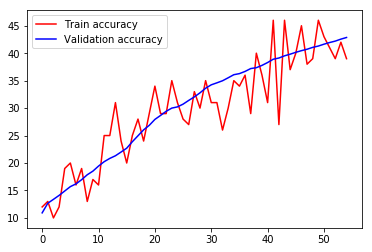

In [22]:
plt.plot(train_accuracy_tract, 'r-', label = 'Train accuracy')
plt.plot(val_accuracy_tract, 'b-', label = 'Validation accuracy')
plt.legend()
plt.show()